# question answering and dialogue system

## definition

| Attributes          | Question Answering Systems                           |
|---------------------|------------------------------------------------------|
| Input               | a single question (image, text)                      |
| Output              | a single direct and specific answer to a question    |
| Scope               | single turn                                          |
| Type                | Factoid vs. Non-factoid, Open-domain vs. Closed-domain, simple vs. compositional, IR-based vs. KB-based vs. hybrid |
| Components          | Question Understanding, Document Retrieval, Answer Extraction |
| Algorithm           | rule-based, IR-based, neural                         |
| Evaluation Metrics  | Recall, F1 score, MRR                                |
| Benchmark Datasets  | SQuAD, TREC-QA, MS MARCO, CNN/Daily Mail, QuizBowl   |
| Information Source  | doc collections, Knowledge bases, user input (a passage/table/image) |


## history

| Year | Era | QA Systems | QA Dataset |
| ---- | --- | ---------- | ---------- |
| 1960s | Knowledge-based and Close-domain | BASEBALL (baseball games) | No |
| 1970s-1980s | More Complex Knowledge-based and Close-domain | LUNAR (moon rock) | No |
| 1990s | IR-based | Open-domain | TREC-QA |
| 2000s | IR-based and Open-domain | IBM Watson | AQUAINT, CLEF QA |
| 2010s-Present | Neural | Google's Knowledge Graph, Google's BERT, Stanford Attentive Reader | bAbI, CNN/Daily Mail, WikiQA, SQuAD, MS MARCO, QuizBowl, TriviaQA, CoQA, QuAC, HotpotQA, Natural Questions, EMR QA |


## system type

Factoid vs. Non-factoid: 

- Factoid questions: ask concrete, factual pieces of information, such as dates, names, or places.

    objective and verifiable: "Who is the president of the United States?" 

- Non-factoid questions: ask for explanations, definitions, procedures, or opinions, require more detailed or explanatory answers. 

    objective: "How does photosynthesis work?" 
    
    subjective: "Why is Picasso considered a great artist?"

Open-domain vs. Closed-domain: 

- Open-domain: various topics, retrieve information from a wide variety of sources. 

- Closed-domain: focus on a specific topic, rely on a specific set of documents or a domain-specific knowledge base.

Simple vs. Compositional: 

- Simple questions: a single fact or piece of information. 

    "Who is the president of China?"

- Compositional questions: require combining information from multiple sources or reasoning over several facts. 

    "Who is the president of the country with the largest population?", 1. identifying the country with the largest population 2. identifying the president of that country.

IR-based vs. KB-based vs hybrid: 

- Information Retrieval (IR): 

    1. question processing: query formulation and answer type detection

    2. document and passage retrieval: document indexing -> document retrieval ( large document collections (PubMed, Wiki)) -> relevant docs -> passage retrieval -> relevant passages
    
    3. answer processing (reading comprehension): extract a span as answer directly from retrieved passages.

- Knowledge-based (KB): 

    1. convert a query to a semantic representation
    
        "What states border Texas?" -> λx.state(x)∧borders(x,texas) 

    2. query a **structured** database to find answer.

    3. convert structured answer to unstructured text

- Hybrid Systems: combines IR (**unstructued** )with knowledge base (**structured**). 

    - IR-to-KB: 1. IR: find relevant documents 2. make a knowledge base from structured information in these documents 3. query the knowledge base by semantic representation of question. e.g., OpenAI system for the TriviaQA benchmark is an example of this approach.

    - DeepQA system in IBM Watson: 1. IR: find candidate answers in relevant documents; KB: find candidate answers in knowledge base. 2. choose the best answer: score and rank candidate answers based on evidence from various sources (other knowledge bases and text data).



## evaluation

- Adversarial examples: adding an unrelated sentence that includes the answer to the question but is out of the context might lead the model to choose this wrong answer.

- metrics of factoid question answering: mean reciprocal rank (MRR) 

    $$
    MRR = \frac{1}{N}\sum_{i=1}^N \frac{1}{\text{rank i}}
    $$

    assumes output is a list of ranked answers, rank i is ranking of correct answer of example i.

## non-neural IR system

<img src='https://www.researchgate.net/profile/Mammad-Hajili-2/publication/328861207/figure/fig1/AS:691538191470594@1541886961965/The-architecture-of-IR-based-question-answering-system.ppm'/>

IR-based factoid question answering has three stages: 

- question processing: 

    - query formulation: rephrase the question to a substring of possible declarative answers. 
    
        “when was the laser invented?” -> “the laser was invented”
        
        “where is the Valley of the Kings?” -> “the Valley of the Kings is located in”. 
    
    - answer type detection: human, location, time, reason, description, etc determined by headword of the first NP after the question’s wh-word.

        "What is the state **flower** of California?" -> entity

        “Who **founded** Vir- gin Airlines?” -> human

- document and passage retrieval

    - source: web or document collections (PubMed, Wiki)

    - document retrieval: retrieve n most relevant docs by document ranking. features: TF-IDF scores, doc length, query-doc similarity, doc popularity (PageRank), metadata (date, author)

    - passage retrieval: passage segmentation (divide n docs to x passages),  retrieve y most relevant passages by passage ranking. features: passage length, NER match, query-passage similarity, doc rank, passage position within doc, Number of question terms in the passage.

    - span retrieval: retrieve z most relevant spans by span ranking. features: span length, NER match, Position of the span within the passage, span-question similarity, Number of question terms in the span


- answer extraction

    - feature-based ML: span of highest score is final answer. features: **answer type match**, pattern match, keyword match, novelty factor, keyword distance, apposition features, punctuation location, sequences of question terms

    - n-gram tiling: only in Web search based on redundancy. 
    
        - n-gram mining (extracts all unigrams, bigrams, and trigrams from the snippets from web). Snippets are summarization from a webpage that appear in search engine results. They provide a quick preview of the page's content, helping users to decide if the page is relevant to their query before they click on it. include the search keywords, and can be either automatically generated from the page content or manually specified by the webpage creator using meta tags.
        
        - n-gram filtering (n-grams are scored based on answer type match). 
        
        - n-gram tiling (greedy algorithm: start with highest-score n-gram and combine other n-grams to form longer sentence, removing lower-scoring n-gram and adding higher-scoring n-gram until a final answer is constructed )

    - **neural reading comprehension**: see notes below

# Neural Reading Comprehension QA system

## overview

**Problem Formulation**

- input: 

    - a passage/image/table p of m tokens $p=(p_1, ..., p_m), m \approx 100$

    - a question q of l tokens $q = (q_1, ..., q_l),  l \approx 15$

- output: an answer (a span in context) (start_id, end_id) 

- cross-entropy loss: average sum of the negative log probabilities of the true start and end indices by the predicted distributions over all N examples:

    $$
    L = -\frac{1}{N}\left(\sum_i^N \log P_{start}(y_{start, i}) + \log P_{end}(y_{end, i})\right)
    $$

    $y_{start, i}$ and $y_{end, i}$ are ground truth indices of ith example

**Neural Model**

difference between seq2seq model is that QA task only has 2 outputs (start and end position of token in passage), so don't need a autoregressive decoder

- bi-LSTM with attention: attention between question and passage = attention(P, Q) + attention(Q, P)

    [Stanford Attentive Reader](https://aclanthology.org/P16-1223.pdf), DrQA,BiDFA,  Match-LSTM, ，Dynamic coattention network, R-Net, ReasoNet

- BERT-based: self-attention between the concatenation of question and passage =
attention(P, P) + attention(P, Q) + attention(Q, P) + attention(Q, Q)

**SQuAD: most popular reading comprehension dataset**

- crowd-sourced data: a large number of human create or annotate datasets via the Internet.

    100k (passage, question, answer) triples

    passages: from English Wiki, 100-150 words

    answer: a short span of text. (limitation: not all questions can be answered in this way)

- **evaluation metrics: exact match (0 or 1) and F1 (partial credit)**

    dev set and test set: each question has 3 gold answers. 
    
    compare the predicted answer to each gold answer (a, an, the, punctuations are removed) and take max scores. 
    
    take the average of all the examples for both exact match and F1.

- Example:

    Q: What did Tesla do in December 1878?

    gold answers: {left Graz/left Graz/left Graz and severed all relations with his family}

    Prediction: {left Graz and served}

    Exact match: max{0, 0, 0}  = 0

    F1: max{0.67, 0.67, 0.61}  = 0.67


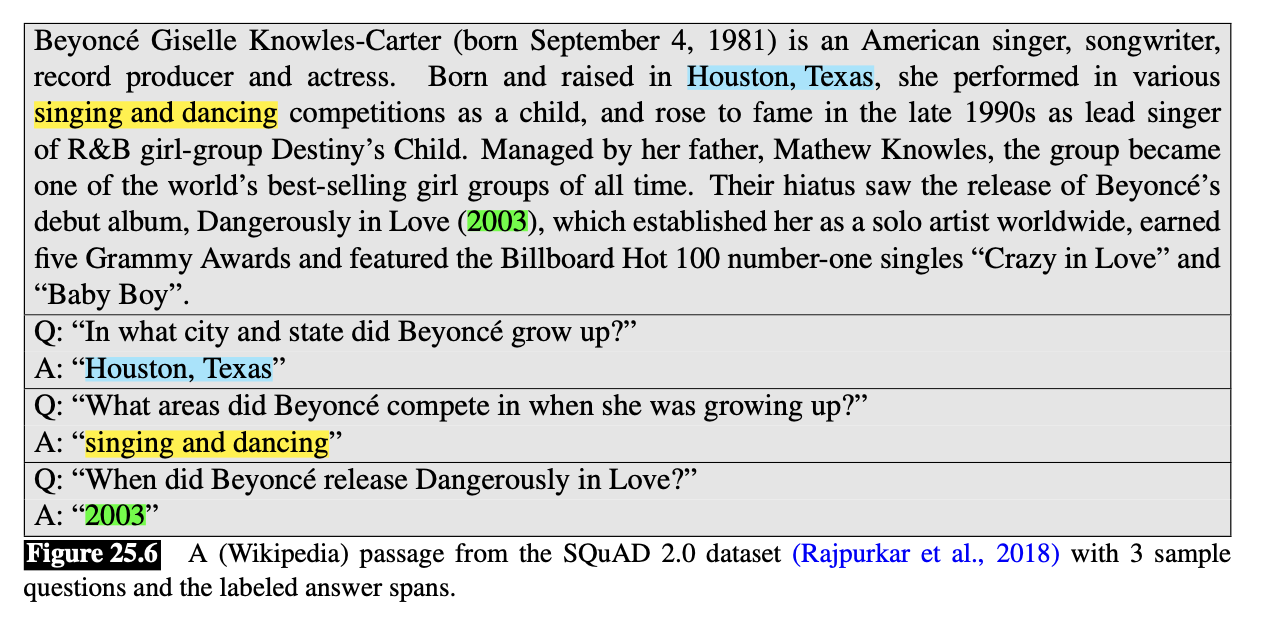

## bi-LSTM with attention

### Document Reader Question Answering (DrQA)

[DrQA, Chen et al. (2017)](https://arxiv.org/pdf/1704.00051.pdf), introduced by Facebook AI Research (FAIR), is designed to answer factoid questions (questions that have a factual answer) using large-scale document collections as the knowledge source.

question "When did Beyonce release Dangerously in Love?"

passage starting "Beyonce’s debut album, Dangerously in Love (2003)"

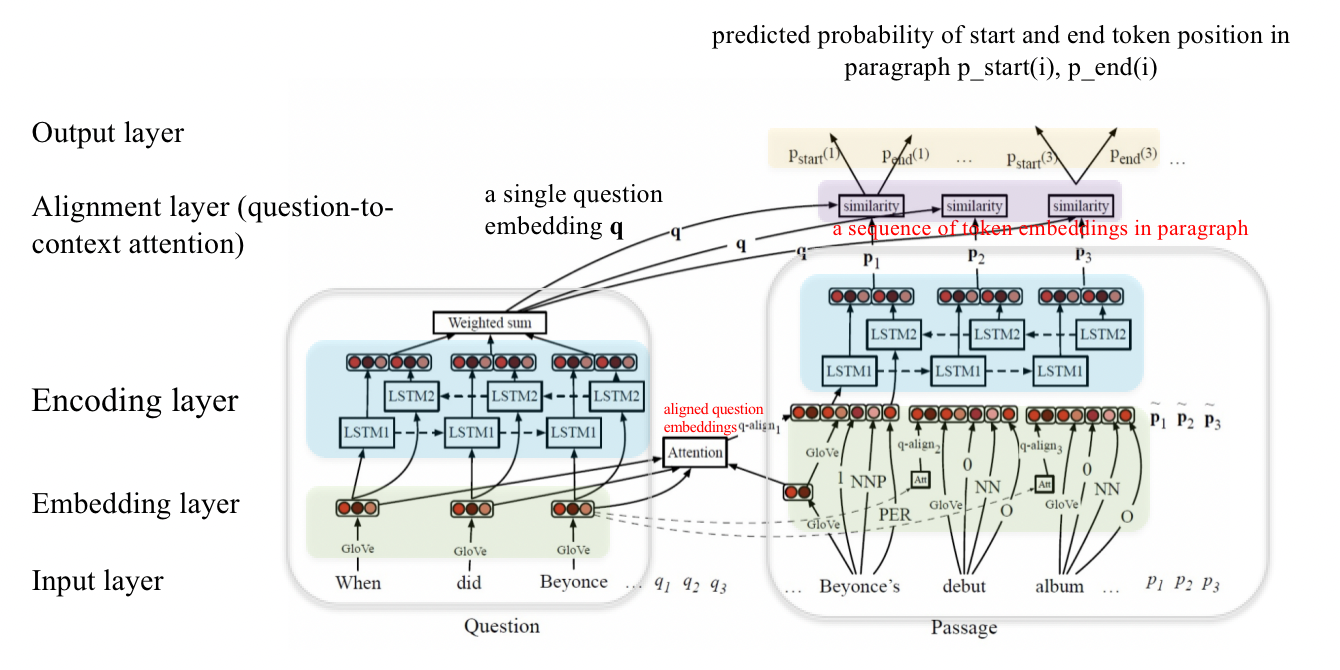

**Input Layer**

- question: a sequence of indices for each token in a question. $q_1, ..., q_l$

- passage: a sequence of indices for each token in a passage. $p_1, ..., p_m$

**Embedding Layer**

- question: a sequence of GloVe Embeddings for each token in a question. $E(q_1), ..., E(q_l)$

- passage: a sequence of concatenated embeddings of multiple features for each token in a passage. $\tilde{\mathbf{p}}_1, ..., \tilde{\mathbf{p}}_m$
    
    - pretrained word embeddings GloVe 300D

    - one-hot linguistic features (POS tag, NER tag)

    - unigram term frequency

    - 3 binary features: exact match (whether the word in passage appears in question), uncased, lemma

    - aligned question embeddings $f_{align}(p_i)$: (question-to-passage attention) aligns similar but non-identical words between the passage and question.this alignment is **semantic-sensitive**, irrespective of the surrounding context. $\alpha$ is a simple 1-layer FFNN. score function is dot product. 

        $$
        \begin{align}
        &f_{align}(p_i) = \sum_j a_{i,j} E(q_j)\\[1em]
        &a_{i,j} = \frac{\exp(\alpha(E(p_i)) \cdot \alpha(E(q_j)))}{\sum_{j'} \exp(\alpha(E(p_i)) \cdot \alpha(E(q_{j'})))}
        \end{align}
        $$

        $a_{i,j}$: attention weight encodes the similarity between ithe word in passage $p_i$ and each question word $q_j$


**Encoding Layer**: 2 separate bi-LSTM

- question: a single question embedding $\mathbf{q} \in \mathbb{R}^h$. weighted sum of hidden states of each word in question $q_i$. 

    $$
    \begin{align}
    &\mathbf{h}_1, ..., \mathbf{h}_l = \text{bi-LSTM 1}(E(q_1), ..., E(q_l))\\[1em]
    &\mathbf{q} = \sum_j^l b_j \mathbf{h}_j\\[1em]
    &b_j = \text{softmax}(\mathbf{W}^T\mathbf{h}_j)
    \end{align}
    $$

    $\mathbf{W}$ is weight matrix

- passage: a sequence of word embeddings in passage, which are concatenated forward and backward hidden states. $\{ \mathbf{p}_i \in \mathbb{R}^h\}, i=1, ..., m$

    $$
    \mathbf{p}_1, ..., \mathbf{p}_m = \text{bi-LSTM 2}(\tilde{\mathbf{p}}_1, ..., \tilde{\mathbf{p}}_m)
    $$

**Alignment Layer (question-to-passage Attention)**: this alignment is **context-sensitive**, takes into account the surrounding context of each word in the passage, as represented by the outputs of the LSTM layer. 

$$
\alpha_i = \text{softmax} (\mathbf{q}^T W_a \mathbf{p}_i)\\[1em]
\mathbf{a} = \sum_j \alpha_j \mathbf{p}_i
$$

each token in the passage is aligned with each token in the question, creating an alignment vector $\mathbf{a}$, which is weighted combination of all paragraph embeddings. model attends to tokens in the passage that are most relevant to the question. 

score function is bilinear

**Prediction Layer**: 2 separate classifiers parameterized by $W_{start}$ and $W_{end}$

- classifier 1: predict start token position of answer span

    $$
    P_{start}(i) = \text{softmax} (W_{start}^T \mathbf{a}), i = 1, ..., m
    $$

- classifier 2: predict end token position of answer span

    $$
    P_{end}(i) = \text{softmax} (W_{end}^T \mathbf{a}), i = 1, ..., m
    $$


### Bi-Directional Attention Flow (BiDAF)

[Bi-directional attention flow for machine comprehension, ICLR 2017](https://arxiv.org/pdf/1611.01603.pdf)

<img src="https://production-media.paperswithcode.com/models/bidaf.png-0000000933-7152061c.png"/>

**Input Layer**

- question: a sequence of indices for each token in a question. $q_1, ..., q_l$

- passage: a sequence of indices for each token in a passage. $p_1, ..., p_m$


**Embedding Layer**

both question embeddings and context embeddings are calculated by concatenating pretrained word Embeddings from GloVe and character-level word embeddings from CNN, then pass to a two-layer Highway Network $f$

- question: a sequence of word embeddings for each token in a question. $e(q_1), ..., e(q_l)$

- context: a sequence of word embeddings for each token in a passage. $e(c_1), ..., e(c_m)$
  
    $$
    e(q_i) = f([\text{GloVe}(q_i);\text{charEmb}(q_i)])\\[1em]
    e(c_i) = f([\text{GloVe}(c_i);\text{charEmb}(c_i)])
    $$


**Encoding Layer**: 2 separate bi-LSTM

- question: a sequence of contextual embeddings for each word in question

$$
\begin{align}
&c_i = [\vec c_i\ ; \overleftarrow c_i] \in \mathbb{R}^{2H}\quad i=1, .., m\\
&\vec{c_i} = LSTM(\vec c_{i-1}, e(c_i)),\ \overleftarrow{c_i} = LSTM(\overleftarrow c_{i+1}, e(c_i)) \\
\end{align}
$$

- context: a sequence of contextual embeddings for each word in passage

$$
\begin{align}
&q_i = [\vec q_i\ ; \overleftarrow q_i] \in \mathbb{R}^{2H}\quad  i=1, ..., l\\
&\vec{q_i} = LSTM(\vec q_{i-1}, e(q_i)),\ \overleftarrow{q_i} = LSTM(\overleftarrow q_{i+1}, e(q_i)) \\
\end{align}
$$

**Alignment Layer (bidirectional Attention)**: modeling interactions between query and context

- Similarity Score: for each context-query pair $(c_i, q_j)$

    $$S_{i,j} = W_{sim}^T [c_i; q_j; c_i \odot q_j]\in \mathbb{R} \quad W_{sim}\in \mathbb{R}^{6H}$$

- Context-to-Query Attention: which word in query are relevant to ith word in passage.

    $$
    \alpha_{i}  = \text{softmax}(S_{i} )\in \mathbb{R}^l\\
    a =\sum_{j=1}^l \alpha_{i,j} q_j \in \mathbb{R}^{2H}
    $$

- Query-to-Context Attention: which word in passage are relevant to jth word in query.

    $$
    \beta_{j}  = \text{softmax}(\max_{i=1}^m S_{i,j} )\in \mathbb{R}^m\\
    b =\sum_{i=1}^m \beta_{j} c_i \in \mathbb{R}^{2H}
    $$

- Final Output:

    $$g_i = [c_i; a_i; c_i \odot a_i; c_i \odot b] \in \mathbb{R}^{8H}$$

**Modelling Layer**: modeling interactions within context words

$$
m_i = BiLSTM(g_i)\in \mathbb{R}^{2H}
$$

**Prediction Layer**: 2 separate classifiers parameterized by $W_{start}\in \mathbb{R}^{10H}$ and $W_{end}\in \mathbb{R}^{10H}$

- classifier 1 (dense layer + softmax): predict start token position of answer span

    $$
    P_{start}(i) = \text{softmax} (W_{start}^T [\mathbf{g_i};\mathbf{m_i}]), i = 1, ..., m
    $$

- classifier 2 (BiLSTM + softmax): predict end token position of answer span

    $$
    P_{end}(i) = \text{softmax} (W_{end}^T [\mathbf{g_i};\mathbf{m_i}']), i = 1, ..., m\\[1em]
    m_i' = BiLSTM(g_i)\in \mathbb{R}^{2H}
    $$

## recursive NN: QANTA

**input**: 

- a dependency parse tree of question $t$ and ground truth answer $c$. 

- Each node in the parse tree is associated with a word $w$, a word vector $x_w$, and a hidden vector $h_n \in \mathbb{R}^d$.

**output**: a dependency parse subtree of input parse tree that contains predicted answer

**architecture**: recursive neural network

- $W_e \in \mathbb{R}^{d \times V}$: word embedding matrix for encode each word $w$ into a word vector $x_w$. V is vocabulary.

- $W_r \in \mathbb{R}^{d \times d}$: matrix for each dependency relation $r$, |R| = 46 from Quiz Bowl dataset.

- $W_v \in \mathbb{R}^{d \times d}$: matrix to incorporate the each word vector $x_w$ at a node into the node vector $h_n$.

hidden representation at each node is computed **recursively**

1. For leaf nodes, the hidden representation is computed as: (e.g., a node with the word "helots")

   $$h_{\text{helots}} = f(W_v \cdot x_{\text{helots}} + b)$$

   where $f$ is a non-linear activation function like tanh and $b$ is a bias term.

2. For interior nodes, the hidden representation is computed as: (e.g., a node with the word "called" that is a parent of "helots")

   $$h_{\text{called}} = f(W_{\text{DOBJ}} \cdot h_{\text{helots}} + W_v \cdot x_{\text{called}} + b)$$

   Here, DOBJ is the dependency relation between "called" and "helots".

3. The composition equation for any node $n$ with children $K(n)$ and word vector $x_w$ is:

   $$h_n = f(W_v \cdot x_w + b + \sum_{k \in K(n)} W_{R(n,k)} \cdot h_k)$$

   where $R(n, k)$ is the dependency relation between node $n$ and child node $k$.


objective: minimizes sum of error over all sentences $T$ normalized by the number of nodes $N$ in the training set,

$$
J(\theta) = \frac{1}{N} \sum_{S \in T} C(t, \theta)= \frac{1}{N} \sum_{S \in T} \left[\sum_{s \in S} \sum_{z \in Z} L[\text{{rank}}(c, s, Z)\max(0,1 - x_c \cdot h_s + x_z \cdot h_s)]\right]
$$

parameters $\theta = (W_r \in R, W_v, W_e, b)$, where $R$ represents all dependency relations in the data.

$S$: a set of all nodes $s$ in the sentence’s dependency tree

$Z$: a subset of randomly selected $j$ incorrect answers from all incorrect answers of a sentence $t$ paired with its correct answer $c$.

$\text{{rank}}(c, s, Z)$: rank of correct answer $c$ w.r.t incorrect answers $Z$. 

## BERT

- input: [CLS] + question + [SEP] + passage + [SEP]

- transformer encoder

- linear layer and softmax

- output: start token position, end token position in passage

    $$
    P_{start}(i) = \text{softmax} (W_{start}^T H_i), \quad
    P_{end}(i) = \text{softmax} (W_{end}^T H_i),  i = 1, ..., m
    $$

    $H=[h_1, ..., h_m]$ are hidden states of passage

    span from position i to j $(j \geq i)$ of highest score $W_{start}^T H_i + W_{end}^T H_j$ is model prediction 

<img src='https://ars.els-cdn.com/content/image/1-s2.0-S1532046421001283-gr1.jpg'/>

# Neural Open-domain QA system

## overview

**problem formulation**

- input: a query Q

- output: an answer A

- information source: a large collection of documents $D = D_1, ..., D_N$

**neural model**: 

- framework: retriever-reader, retriever-generator, generator, retriever

- retriever $f(D, Q)\rightarrow P_1, ..., P_K, \quad K \approx 100$ predefined

    - sparse retrieval model: TF-IDF, BM25. create sparse, high-dimensional (vocab size) vectors 

    - dense retrieval model: BERT. learn dense, lower-dimensional vectors of question and passages. capture semantic relationships.

- reader (discriminative/extractive) $g(Q, \{P_1, ..., P_K\}) \rightarrow A$

    predict start and end positions of the answer span within passage. BiDAF, DrQA

- generator (generative/abstractive): generate answers by itself. FID (dense retriever), ChatGPT (no retriever at all!)

## framework

<img src='https://lilianweng.github.io/posts/2020-10-29-odqa/QA-summary.png' />

### retriever-reader

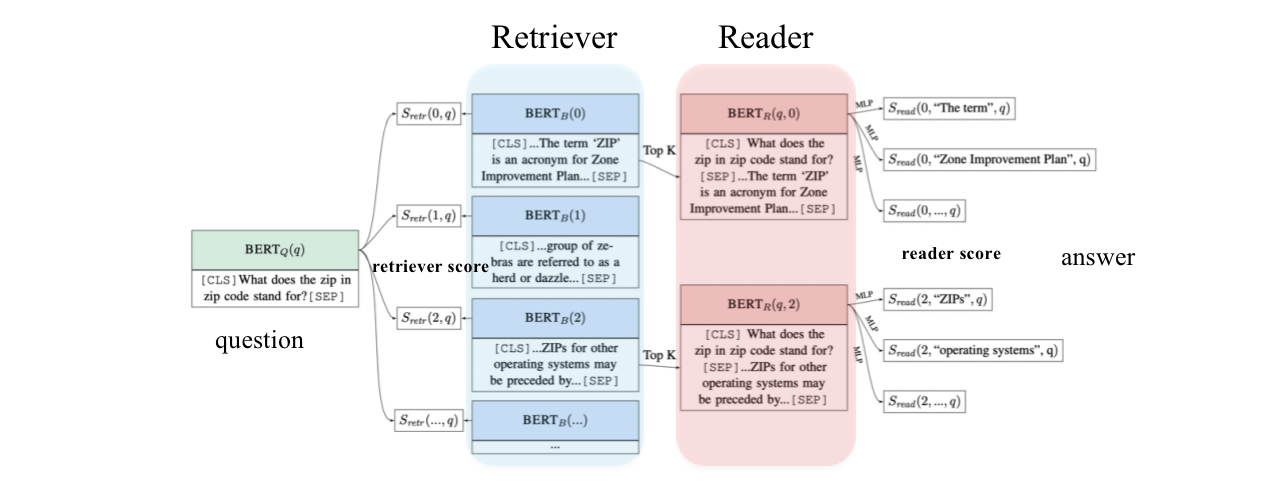

ORQA (Open Retrieval Question Answering system)

Lee et al., 2019 Latent Retrieval for Weakly Supervised Open Domain Question Answering

jointly training retriever and reader

- BERT retriever: pretrained on a large corpus and fine-tuned for passage retrieval task. produce embeddings for both questions and passages, which are then take dot product to compute $S_{retr}$.

- BERT reader: pretrained on a large corpus and fine-tuned for answer span prediction task. Given a question and a passage, it predicts the start and end positions of the answer span within the passage and assigns an $S_{read}$ score.

### retriever-only

Dense-Sparse Phrase Index: Seo et al., 2019. Real-Time Open-Domain Question Answering with Dense-Sparse Phrase Index



<img src='https://d3i71xaburhd42.cloudfront.net/b29db655a18e7417e1188ba392a06b6314f0cb87/2-Figure1-1.png' />

Lee et al., 2020. Learning Dense Representations of Phrases at Scale

<img src='https://d3i71xaburhd42.cloudfront.net/028128a367e4ae57832155ce789080157710871d/4-Figure1-1.png'/>

### reader-only

<img src='https://1.bp.blogspot.com/-89OY3FjN0N0/XlQl4PEYGsI/AAAAAAAAFW4/knj8HFuo48cUFlwCHuU5feQ7yxfsewcAwCLcBGAsYHQ/s1600/image2.png' />